In [17]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [3]:
def recommend_map_knn(level, job, level_range=5):
    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df.dropna(subset=['level', 'spec_filled', 'map'])
    
    # Filter the dataset to use only the data corresponding to the input job
    relevant_data = df_cleaned[(df_cleaned['level'] >= level - level_range) & 
                               (df_cleaned['level'] <= level + level_range) & 
                               (df_cleaned['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Prepare feature matrix (X) for KNN model: 'level', 'spec_filled'
    X = relevant_data[['level', 'spec_filled']].values
    maps_relevant = relevant_data['map'].values

    # KNN Model for finding similar maps based on features
    knn_relevant = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean')
    knn_relevant.fit(X)

    # Create a feature vector for the input (level, spec_filled)
    input_spec_filled = relevant_data['spec_filled'].mean()  # Use the mean spec_filled value for input
    input_vector = np.array([[level, input_spec_filled]])

    # Find the top 3 nearest neighbors (maps) based on the input features
    distances, indices = knn_relevant.kneighbors(input_vector)
    
    # Get the top 3 map recommendations and their corresponding distances
    recommended_maps = maps_relevant[indices.flatten()]
    recommendation_scores = distances.flatten()

    # Remove duplicate maps if any
    recommended_maps = list(dict.fromkeys(recommended_maps))[:3]  # Limit to 3 unique maps

    # Sort the recommendations by raw distance (lower distance is better)
    sorted_recommendations = sorted(zip(recommended_maps, recommendation_scores), key=lambda x: x[1])

    # Visualize the KNN results
    if isinstance(recommended_maps, list):
        maps = relevant_data['map'].values
        levels = relevant_data['level'].values
        spec_filled = relevant_data['spec_filled'].values
        
        # Plot all data points
        plt.figure(figsize=(8, 6))
        plt.scatter(levels, spec_filled, c='gray', label='Data points', alpha=0.5)

        # Highlight the query point
        plt.scatter(level, input_spec_filled, c='red', label='Query point', s=100, marker='x')

        # Highlight the nearest neighbors
        nearest_neighbors = X[indices.flatten()]
        plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], c='blue', label='Nearest neighbors', s=100, marker='o')

        # Labels and title
        plt.xlabel('Level')
        plt.ylabel('Spec Filled')
        plt.title(f"KNN Visualization for Job: {job} and Level: {level}")
        plt.legend()

        # Show plot
        plt.show()
        
        # Output the recommended maps and their scores (raw distance)
        # Print the similarity scores
        print("Similarity scores for recommended maps:")
        for map_name, score in zip(recommended_maps, recommendation_scores):
            print(f"Map: {map_name}, Score: {score}")
        print("Recommended Maps and Scores:", recommended_maps)

    return sorted_recommendations

# Example usage
# recommended_maps = recommend_map_knn(140, "썬콜", level_range=5)

In [4]:
# Function to get map recommendations based on a given level and job
def recommend_map_svd(level, job, level_range=5):

    # Filter out rows that do not belong to the specified job
    df_job_filtered = df[df['job'] == job]

    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df_job_filtered.dropna(subset=['level', 'job', 'spec_filled', 'map'])
    
    # Calculate map usage frequency for each job
    map_usage_frequency = df_cleaned.groupby(['job', 'map']).size().reset_index(name='usage_count')
    
    # Calculate the total number of interactions for each job
    job_total_count = df_cleaned.groupby('job').size().reset_index(name='total_count')
    
    # Merge the usage count with the total count for each job
    map_usage_frequency = pd.merge(map_usage_frequency, job_total_count, on='job')
    
    # Calculate the percentage usage for each map within each job
    map_usage_frequency['usage_percentage'] = (map_usage_frequency['usage_count'] / map_usage_frequency['total_count']) * 100
    
    # Filter out maps used in less than 5% of the total interactions for each job
    valid_maps_per_job = map_usage_frequency[map_usage_frequency['usage_percentage'] >= 5]
    
    # Now filter the original dataframe to only keep rows with maps that meet the usage threshold
    df_cleaned_filtered = df_cleaned[df_cleaned['map'].isin(valid_maps_per_job['map'])]
    
    # Prepare the data for the recommendation system
    # Create a user-item interaction matrix where rows = users (party_id), columns = maps
    user_map_matrix = df_cleaned_filtered.pivot_table(index='party_id', columns='map', values='spec_filled', aggfunc='mean').fillna(0)
    
    # Apply Matrix Factorization using TruncatedSVD
    svd = TruncatedSVD(n_components=3, random_state=42)  # Using 3 latent factors for this example
    matrix_factorized = svd.fit_transform(user_map_matrix)
    
    # Get the cosine similarity between maps in the reduced space
    map_similarity = cosine_similarity(matrix_factorized.T)

    # Filter data based on the given level and job
    level_range_min = level - level_range
    level_range_max = level + level_range
    relevant_data = df_cleaned_filtered[(df_cleaned_filtered['level'] >= level_range_min) & 
                                       (df_cleaned_filtered['level'] <= level_range_max) & 
                                       (df_cleaned_filtered['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Get the list of maps from the filtered data
    maps_relevant = relevant_data['map'].unique()

    # Ensure that the maps are present in the user_map_matrix
    valid_maps = [map_name for map_name in maps_relevant if map_name in user_map_matrix.columns]
    
    if not valid_maps:
        return "No valid maps available for recommendation."

    # Get the index of relevant maps in the reduced matrix (svd.transform)
    map_indices = [user_map_matrix.columns.get_loc(map_name) for map_name in valid_maps]
    
    # Ensure map_indices do not exceed the range of the reduced matrix (which has 3 factors)
    map_indices = [index for index in map_indices if index < len(map_similarity)]

    # Now calculate similarity scores for each relevant map with all other maps in the reduced matrix
    scores = np.mean(map_similarity[map_indices], axis=0)

    # Sort the scores and get top 3 recommended maps
    recommended_indices = np.argsort(scores)[::-1][:3]
    recommended_maps = user_map_matrix.columns[recommended_indices]
    
    # Visualization of the SVD components and map recommendations
    # Visualize the maps in the SVD space (2D for simplicity)
    plt.figure(figsize=(10, 8))
    
    # Plot all maps in the reduced space (SVD components)
    plt.scatter(matrix_factorized[:, 0], matrix_factorized[:, 1], label="Maps", alpha=0.5, c='gray')
    
    # Highlight the recommended maps in a different color
    for idx in recommended_indices:
        plt.scatter(matrix_factorized[idx, 0], matrix_factorized[idx, 1], label=f"Recommended: {recommended_maps[idx]}", s=100, edgecolors='black')
    
    # Add labels for the recommended maps
    for idx in recommended_indices:
        plt.annotate(recommended_maps[idx], (matrix_factorized[idx, 0], matrix_factorized[idx, 1]), fontsize=12, ha='right', color='black')

    # Labeling and formatting the plot
    plt.title(f"SVD Map Visualization for Job: {job} and Level: {level}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend()
    plt.show()

    # Print the unique maps after preprocessing
    print("Unique maps after preprocessing:")
    print(df_cleaned_filtered['map'].unique())

    # Print the similarity scores
    print("Similarity scores for recommended maps:")
    for map_name, score in zip(recommended_maps, scores[recommended_indices]):
        print(f"Map: {map_name}, Score: {score}")
    
    # Output the recommended maps
    print("Recommended Maps:", recommended_maps)
    # Return the top 3 recommended maps
    return recommended_maps.tolist()

# Example usage
# recommended_maps = recommend_map_svd(140, "썬콜", level_range=5)

In [5]:
# recommended_maps = recommend_map_knn(140, "용기사", level_range=5)
# recommended_maps = recommend_map_svd(140, "용기사", level_range=5)

In [6]:
# Step 1: Preprocess the data for t-SNE
def preprocess_data_for_tsne(df, numerical_features=["level", "spec_filled"], categorical_features=["job", "map"]):
    """
    Preprocesses the data for t-SNE:
    - Encodes categorical features (e.g., job, map).
    - Imputes missing values for numerical features (not filling with 0).
    - Normalizes numerical features.
    """
    # One-Hot Encode categorical features (e.g., job, map)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_cats = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

    # Impute missing values for numerical columns with the mean (instead of filling with 0)
    imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer.fit_transform(df[numerical_features])  # Impute missing numerical values

    # Normalize numerical features (including spec_filled)
    scaler = StandardScaler()
    normalized_nums = scaler.fit_transform(df[numerical_features])
    normalized_df = pd.DataFrame(normalized_nums, columns=numerical_features)

    # Combine numerical and categorical features
    combined_df = pd.concat([normalized_df, encoded_df], axis=1)
    return combined_df

# Step 2: Apply t-SNE to the data
def apply_tsne(df, perplexity=30, learning_rate=200, n_iter=1000):
    """
    Apply t-SNE to the dataset and return the 2D results.
    """
    # Preprocess the data
    processed_data = preprocess_data_for_tsne(df)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(processed_data)

    # Add t-SNE results to the DataFrame
    df["tsne_dim1"] = tsne_results[:, 0]
    df["tsne_dim2"] = tsne_results[:, 1]

    return df

# Step 3: Identify outliers based on t-SNE results and filter the top 0.1%
def filter_outliers_by_tsne(df, top_percentile=99.9):
    """
    Filter out the top n% (e.g., 0.1%) outliers based on t-SNE distance.
    """
    # Using NearestNeighbors to compute distances between points
    neighbors = NearestNeighbors(n_neighbors=2)  # Find the closest point (itself + 1 neighbor)
    neighbors.fit(df[["tsne_dim1", "tsne_dim2"]])
    distances, _ = neighbors.kneighbors(df[["tsne_dim1", "tsne_dim2"]])

    # Calculate the distance from the nearest neighbor
    df["distance_to_nearest"] = distances[:, 1]  # distance to the second nearest (ignoring self)

    # Calculate the threshold for the top n% outliers
    distance_threshold = np.percentile(df["distance_to_nearest"], top_percentile)
    print(f"Filtering out the top {top_percentile}% outliers with distance greater than {distance_threshold}")

    # Identify the outliers (rows that are filtered out)
    outliers = df[df["distance_to_nearest"] > distance_threshold]
    
    # Filter out the outliers from the original df
    df_filtered = df[df["distance_to_nearest"] <= distance_threshold]

    return df_filtered, outliers

# Step 4: Visualize the t-SNE results
def visualize_tsne(df):
    """
    Visualizes the t-SNE results and shows the distribution of job-map combinations.
    """
    plt.figure(figsize=(12, 8))
    
    # Create the scatter plot
    sns.scatterplot(data=df, x="tsne_dim1", y="tsne_dim2", hue="map", style="job", palette="tab20", s=100, alpha=0.7)
    plt.title("t-SNE Visualization of Job-Map Combinations", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(True)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Job / Map", fontsize=12)
    plt.tight_layout()
    plt.show()

In [7]:
def process_tsne(df):
    df_with_tsne = apply_tsne(df)  # Apply t-SNE
    df_filtered, outliers = filter_outliers_by_tsne(df_with_tsne, top_percentile=99.9)
    visualize_tsne(df_filtered)
    print(outliers)

In [8]:
# process_tsne(df)

In [15]:
def recommend_map_random_forest(job_input, level_input):
    # Example input for prediction
    job_input = job_input
    level_input = level_input

    # Function to filter the data by the given job
    def filter_data_by_job(job):
        # Filter the DataFrame to only include rows where the 'job' matches the given input
        job_df = df[df['job'] == job]
        return job_df

    # Function to calculate the average spec for the given job and level ±5
    def calculate_average_spec(job, level):
        # Filter the dataset for the given job and levels within ±5 of the input level
        filtered_data = df[(df['job'] == job) & (df['level'].between(level - 5, level + 5))]

        # Calculate the average spec_filled for this subset of data
        avg_spec = filtered_data['spec_filled'].mean()
        return avg_spec

    # Function to train the model for a specific job
    def train_model_for_job(job_df):
        # Label Encoding for the map column (since it's categorical)
        label_encoder = LabelEncoder()
        job_df['map_encoded'] = label_encoder.fit_transform(job_df['map'])

        # Handle missing values for the features
        job_df['spec_filled'] = job_df['spec_filled'].fillna(job_df['spec_filled'].mean())  # Fill missing spec_filled with mean
        job_df['job'] = job_df['job'].fillna(job_df['job'].mode()[0])  # Fill missing job with most frequent job (mode)

        # Prepare features (X) and target (y)
        X = job_df[['level', 'spec_filled']]  # Features (use level and spec_filled)
        y = job_df['map_encoded']  # Target variable (encoded map)

        # Check for missing values and fill them with mean if necessary
        X = X.fillna(X.mean())  # Fill missing values in numerical features with mean (if any)
        y = y.fillna(y.mean())  # Fill missing target values (if any)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the Random Forest Regressor model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")

        return model, label_encoder, X, y_test, y_pred

    # Function to predict the map for a given level and job, and calculate the average spec
    def recommend_map(level, job, model, label_encoder, X):
        # Prepare the input for prediction (use 'level' and 'spec_filled' only)
        input_data = pd.DataFrame({'level': [level], 'spec_filled': [calculate_average_spec(job, level)]})
        input_data = input_data.reindex(columns=X.columns, fill_value=0)  # Ensure columns match the training set

        # Predict the encoded map using the trained model
        predicted_encoded_map = model.predict(input_data)[0]

        # Convert the predicted encoded map back to the original Korean map name
        predicted_map = label_encoder.inverse_transform([int(predicted_encoded_map)])

        # Calculate the average spec for the given level and job (level ±5)
        avg_spec = calculate_average_spec(job, level)

        return predicted_map[0], avg_spec
    
    # Filter the dataset for the given job
    job_df = filter_data_by_job(job_input)

    # Train the model for the selected job
    model, label_encoder, X, y_test, y_pred = train_model_for_job(job_df)

    # Get the recommended map and average spec
    recommended_map, avg_spec = recommend_map(level_input, job_input, model, label_encoder, X)

    print(f"The recommended map for level {level_input}, job '{job_input}' is: {recommended_map}")
    print(f"The average spec for job '{job_input}' and level {level_input} ±5 is: {avg_spec}")

    # Visualization 1: Feature Importance
    def plot_feature_importance(model, X):
        feature_importances = model.feature_importances_
        features = X.columns
        importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
        importance_df = importance_df.sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

    # Visualization 2: Predicted vs Actual values
    def plot_predicted_vs_actual(y_test, y_pred):
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual Map (Encoded)')
        plt.ylabel('Predicted Map (Encoded)')
        plt.title('Predicted vs Actual Map')
        plt.show()

    # Visualization 3: Error Distribution
    def plot_error_distribution(y_test, y_pred):
        errors = y_pred - y_test
        plt.figure(figsize=(8, 6))
        sns.histplot(errors, kde=True, color='blue', bins=20)
        plt.title('Error Distribution (Predicted - Actual)')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.show()

    # Visualize Feature Importance
    plot_feature_importance(model, X)

    # Visualize Predicted vs Actual values (for the training set)
    plot_predicted_vs_actual(y_test, y_pred)

    # Visualize Error Distribution (for the training set)
    plot_error_distribution(y_test, y_pred)

Mean Squared Error: 33.438928862650926
The recommended map for level 125, job '허밋' is: 붉켄
The average spec for job '허밋' and level 125 ±5 is: 2313.4850191354967


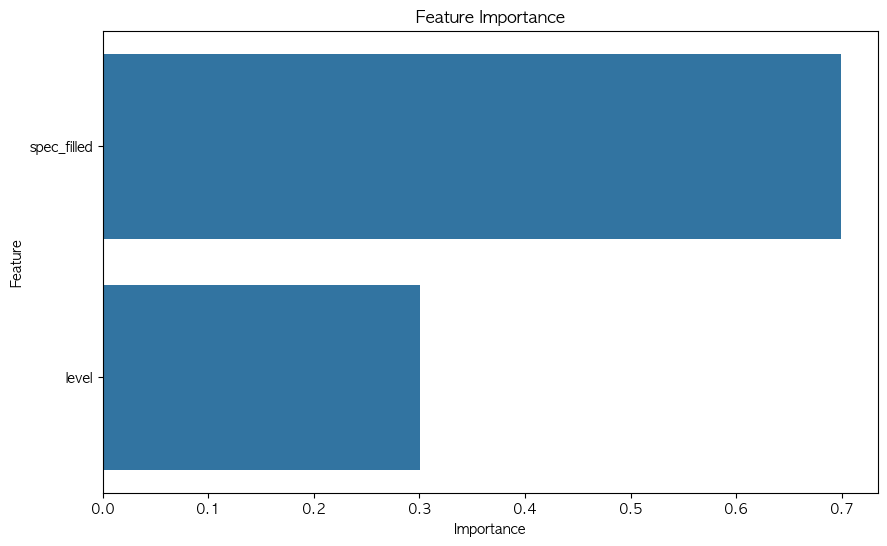

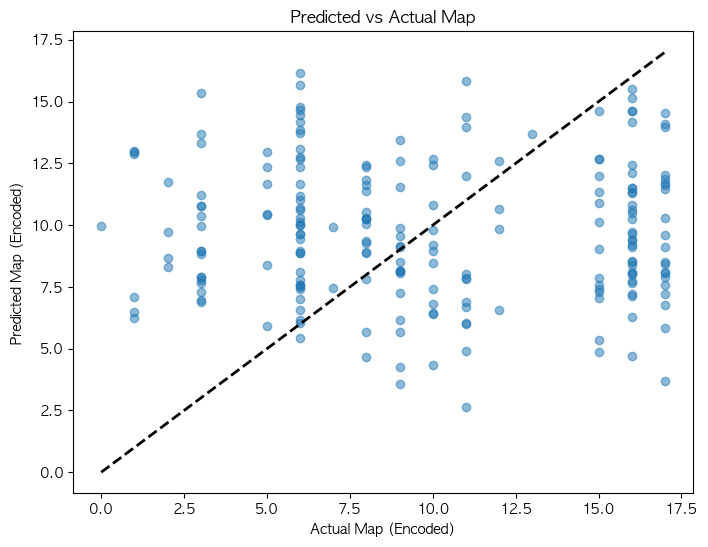

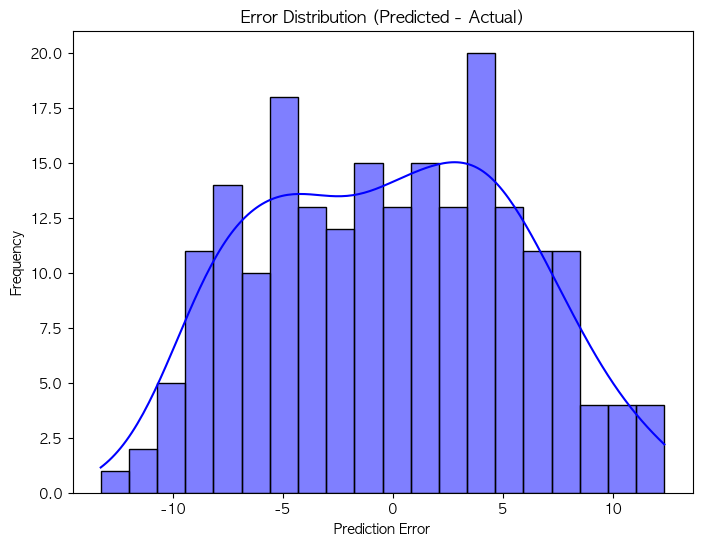

In [16]:
recommend_map_random_forest("허밋", 125)